In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Simple NST/ Image Regeneration (Content part only) from VGG-19

- input: target image
- output: generate image like target image from noise image by using gradient descent

## References

- https://keras.io/examples/generative/neural_style_transfer/

# Load VGG-19 Model

In [2]:
# neural style transfer output

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
def load_vgg():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    # vgg.trainable = False
    
    # extracted feature
    layers = content_layers + style_layers
    outputs_dict = dict([(layer, vgg.get_layer(layer).output) for layer in layers])
    
    # model for nst
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=outputs_dict)
    
    return feature_extractor

# Image Preprocessing

In [4]:
def preprocess_image(image_path, image_size=(500, 500)):
    """
        return: tensor type array. shape (1, height, width, channel).
    """
    
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=image_size 
    )
    
    # image to numpy array shape (h, w, c)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # to shape (1, h, w, c)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)

In [5]:
def deprocess_image(tensor_img):
    img = np.array(tensor_img.numpy()[0], dtype=np.float64)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")

    return img

In [6]:
img_path = "./img/2valk.jpg"
img_tensor = preprocess_image(img_path)

In [7]:
img_tensor

<tf.Tensor: shape=(1, 500, 500, 3), dtype=float32, numpy=
array([[[[  26.060997 ,   -0.7789993,  -13.68     ],
         [  42.060997 ,   14.221001 ,    4.3199997],
         [  70.061    ,   42.221    ,   33.32     ],
         ...,
         [ -57.939003 ,  -89.779    , -104.68     ],
         [ -53.939003 ,  -85.779    , -100.68     ],
         [ -57.939003 ,  -89.779    , -104.68     ]],

        [[  44.060997 ,   21.221    ,   -2.6800003],
         [  73.061    ,   50.221    ,   26.32     ],
         [  36.060997 ,   13.221001 ,  -10.68     ],
         ...,
         [ -47.939003 ,  -83.779    ,  -98.68     ],
         [ -49.939003 ,  -85.779    , -100.68     ],
         [ -48.939003 ,  -84.779    ,  -99.68     ]],

        [[  80.061    ,   55.221    ,   42.32     ],
         [  59.060997 ,   33.221    ,   12.32     ],
         [  61.060997 ,   38.221    ,   14.32     ],
         ...,
         [ -44.939003 ,  -84.779    , -101.68     ],
         [ -50.939003 ,  -90.779    , -107.68   

In [8]:
img_np = deprocess_image(img_tensor)

In [9]:
img_np

array([[[109, 116, 129],
        [127, 131, 145],
        [156, 159, 173],
        ...,
        [ 18,  27,  45],
        [ 22,  31,  49],
        [ 18,  27,  45]],

       [[120, 138, 147],
        [149, 167, 176],
        [112, 130, 139],
        ...,
        [ 24,  33,  55],
        [ 22,  31,  53],
        [ 23,  32,  54]],

       [[165, 172, 183],
        [135, 150, 162],
        [137, 155, 164],
        ...,
        [ 21,  32,  58],
        [ 15,  26,  52],
        [ 20,  31,  57]],

       ...,

       [[ 59,  58,  60],
        [ 65,  64,  66],
        [ 69,  68,  70],
        ...,
        [217, 183, 152],
        [217, 187, 155],
        [213, 184, 149]],

       [[ 66,  65,  67],
        [ 60,  59,  61],
        [ 53,  52,  54],
        ...,
        [207, 167, 134],
        [199, 165, 132],
        [218, 185, 149]],

       [[ 71,  70,  72],
        [ 64,  63,  65],
        [ 72,  71,  73],
        ...,
        [169, 122,  83],
        [168, 125,  87],
        [198, 156, 120]]

# Generated Image Tensor

In [10]:
def load_random_noise_tensor(img_tensor):
    random_noise = np.array(np.random.randint(0, 255, img_tensor.shape))
    gen_tensor = tf.Variable(random_noise, dtype=tf.float32)
    return gen_tensor

In [11]:
gen_tensor = load_random_noise_tensor(img_tensor)

# Compute Loss

In [12]:
def compute_content_loss(base_tensor, gen_tensor, content_layer='block1_conv1', loss_weight=1e-6):
    input_tensor = tf.concat([base_tensor, gen_tensor], axis=0)
    features = model(input_tensor)[content_layer]
    base_feature = features[0]
    gen_feature = features[1] 
    
    return loss_weight*tf.reduce_sum(tf.square(base_feature - gen_feature))

In [13]:
model = load_vgg()

In [14]:
# content layer
content_layer = 'block1_conv1'
output = model(img_tensor)

In [15]:
compute_content_loss(img_tensor, img_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Gradient

In [16]:
@tf.function
def compute_loss_and_grads(base_image_tensor, gen_image_tensor):
    with tf.GradientTape() as tape:
        loss = compute_content_loss(base_image_tensor, gen_image_tensor)
    grads = tape.gradient(loss, gen_image_tensor)
    return loss, grads

# Training Loop

In [17]:
def training_loop(base_tensor, gen_tensor, optimizer, max_iterations=10000):
    for i in range(1, max_iterations+1):
        if (i % 100 == 0) or (i == 1) or (i == max_iterations):
            loss, grads = compute_loss_and_grads(base_tensor, gen_tensor)
            optimizer.apply_gradients([(grads, gen_tensor)])
            print(f"iteration {i:8}, loss {loss:.2f}")
            
        # show image
        if (i % 1000 == 0) or (i == 1) or (i == max_iterations):
            fig = plt.figure(figsize=(5, 5))
            plt.title(f"iteration {i}")
            plt.imshow(deprocess_image(gen_tensor))
            plt.show()
        
        # save image
        if (i % 200 == 0) or (i == 1) or (i == max_iterations):
            save_img_arr = deprocess_image(gen_tensor)
            tf.keras.preprocessing.image.save_img(f"./regenerate_output_img/{i}.jpg", save_img_arr)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("final result")
    plt.imshow(deprocess_image(gen_tensor))
    plt.show()

In [18]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1000.0, decay_steps=500, decay_rate=0.9
    )
)

In [19]:
# load image
img_path = "./img/remember.jpg"
img_size = (500, 500)

# base image/target image tensor
img_tensor = preprocess_image(img_path, img_size)
# random image
gen_tensor = load_random_noise_tensor(img_tensor)

iteration        1, loss 118743.54


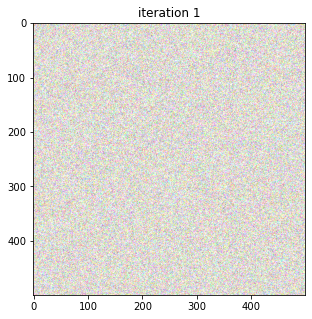

iteration      100, loss 111998.96
iteration      200, loss 105555.25
iteration      300, loss 99334.52
iteration      400, loss 93292.94
iteration      500, loss 87419.52
iteration      600, loss 81736.52
iteration      700, loss 76281.66
iteration      800, loss 71085.66
iteration      900, loss 66180.94
iteration     1000, loss 61598.16


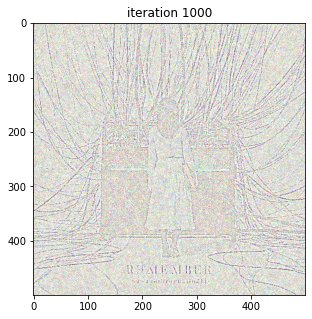

iteration     1100, loss 57354.35
iteration     1200, loss 53453.74
iteration     1300, loss 49888.65
iteration     1400, loss 46647.21
iteration     1500, loss 43709.67
iteration     1600, loss 41054.91
iteration     1700, loss 38658.88
iteration     1800, loss 36499.38
iteration     1900, loss 34551.92
iteration     2000, loss 32793.09


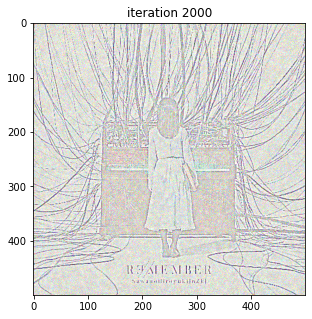

iteration     2100, loss 31202.43
iteration     2200, loss 29760.04
iteration     2300, loss 28448.81
iteration     2400, loss 27253.85
iteration     2500, loss 26161.94
iteration     2600, loss 25160.74
iteration     2700, loss 24239.94
iteration     2800, loss 23390.81
iteration     2900, loss 22605.25
iteration     3000, loss 21876.37


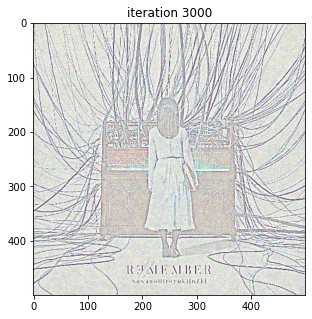

iteration     3100, loss 21198.20
iteration     3200, loss 20565.39
iteration     3300, loss 19973.24
iteration     3400, loss 19417.59
iteration     3500, loss 18895.09
iteration     3600, loss 18402.50
iteration     3700, loss 17936.97
iteration     3800, loss 17496.12
iteration     3900, loss 17077.86
iteration     4000, loss 16680.27


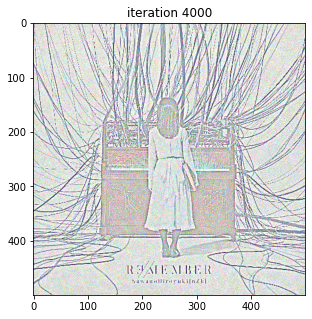

iteration     4100, loss 16301.69
iteration     4200, loss 15940.63
iteration     4300, loss 15595.73
iteration     4400, loss 15265.80
iteration     4500, loss 14949.75
iteration     4600, loss 14646.63
iteration     4700, loss 14355.56
iteration     4800, loss 14075.73
iteration     4900, loss 13806.42
iteration     5000, loss 13547.02


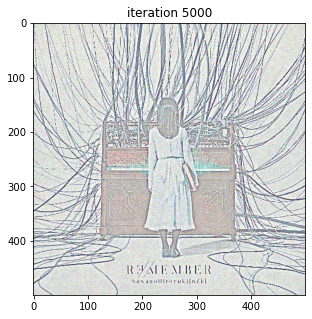

iteration     5100, loss 13296.89
iteration     5200, loss 13055.43
iteration     5300, loss 12822.17
iteration     5400, loss 12596.68
iteration     5500, loss 12378.54
iteration     5600, loss 12167.34
iteration     5700, loss 11962.73
iteration     5800, loss 11764.39
iteration     5900, loss 11572.03
iteration     6000, loss 11385.32


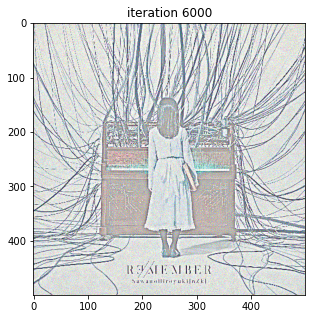

iteration     6100, loss 11203.97
iteration     6200, loss 11027.74
iteration     6300, loss 10856.41
iteration     6400, loss 10689.77
iteration     6500, loss 10527.66
iteration     6600, loss 10369.84
iteration     6700, loss 10216.14
iteration     6800, loss 10066.43
iteration     6900, loss 9920.51
iteration     7000, loss 9778.25


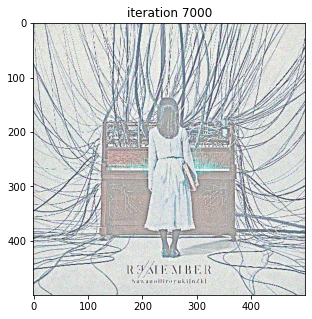

iteration     7100, loss 9639.50
iteration     7200, loss 9504.12
iteration     7300, loss 9372.01
iteration     7400, loss 9243.03
iteration     7500, loss 9117.09
iteration     7600, loss 8994.05
iteration     7700, loss 8873.83
iteration     7800, loss 8756.34
iteration     7900, loss 8641.46
iteration     8000, loss 8529.12


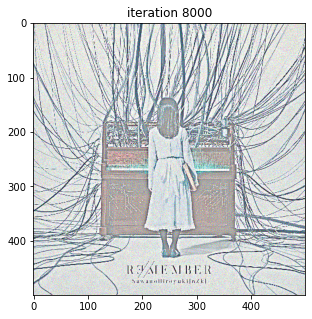

iteration     8100, loss 8419.24
iteration     8200, loss 8311.72
iteration     8300, loss 8206.50
iteration     8400, loss 8103.53
iteration     8500, loss 8002.72
iteration     8600, loss 7904.01
iteration     8700, loss 7807.32
iteration     8800, loss 7712.60
iteration     8900, loss 7619.82
iteration     9000, loss 7528.94


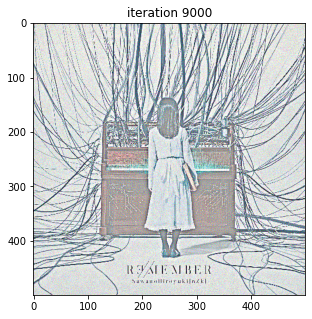

iteration     9100, loss 7439.85
iteration     9200, loss 7352.50
iteration     9300, loss 7266.85
iteration     9400, loss 7182.85
iteration     9500, loss 7100.48
iteration     9600, loss 7019.67
iteration     9700, loss 6940.34
iteration     9800, loss 6862.48
iteration     9900, loss 6786.05
iteration    10000, loss 6711.02


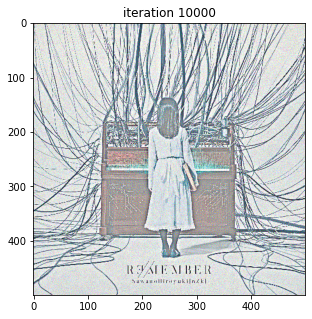

iteration    10100, loss 6637.33
iteration    10200, loss 6564.95
iteration    10300, loss 6493.85
iteration    10400, loss 6423.98
iteration    10500, loss 6355.32
iteration    10600, loss 6287.84
iteration    10700, loss 6221.53
iteration    10800, loss 6156.32
iteration    10900, loss 6092.22
iteration    11000, loss 6029.18


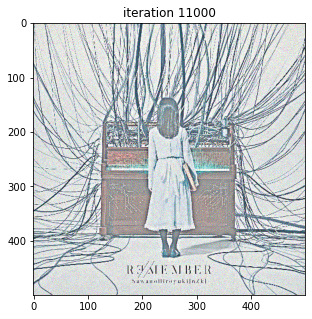

iteration    11100, loss 5967.21
iteration    11200, loss 5906.21
iteration    11300, loss 5846.17
iteration    11400, loss 5787.06
iteration    11500, loss 5728.87
iteration    11600, loss 5671.58
iteration    11700, loss 5615.19
iteration    11800, loss 5559.66
iteration    11900, loss 5504.97
iteration    12000, loss 5451.08


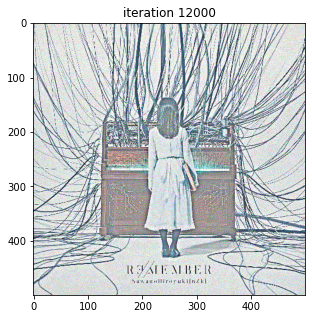

iteration    12100, loss 5397.99
iteration    12200, loss 5345.68
iteration    12300, loss 5294.11
iteration    12400, loss 5243.26
iteration    12500, loss 5193.12
iteration    12600, loss 5143.66
iteration    12700, loss 5094.88
iteration    12800, loss 5046.75
iteration    12900, loss 4999.28
iteration    13000, loss 4952.45


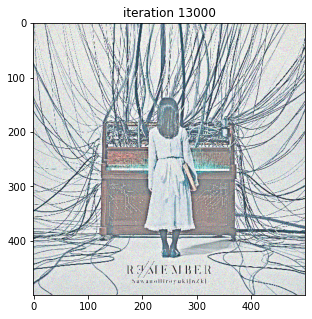

iteration    13100, loss 4906.27
iteration    13200, loss 4860.71
iteration    13300, loss 4815.72
iteration    13400, loss 4771.31
iteration    13500, loss 4727.49
iteration    13600, loss 4684.26
iteration    13700, loss 4641.58
iteration    13800, loss 4599.44
iteration    13900, loss 4557.85
iteration    14000, loss 4516.78


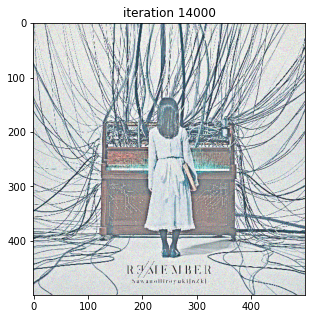

iteration    14100, loss 4476.24
iteration    14200, loss 4436.21
iteration    14300, loss 4396.68
iteration    14400, loss 4357.66
iteration    14500, loss 4319.10
iteration    14600, loss 4281.01
iteration    14700, loss 4243.40
iteration    14800, loss 4206.22
iteration    14900, loss 4169.49
iteration    15000, loss 4133.19


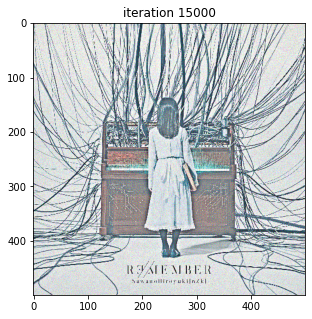

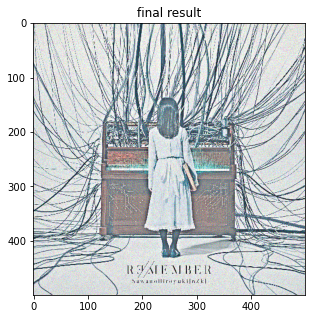

In [20]:
training_loop(img_tensor, gen_tensor, optimizer, 15000)

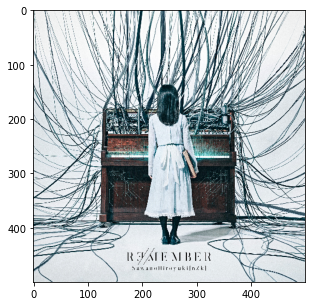

In [21]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(img_tensor))
plt.show()

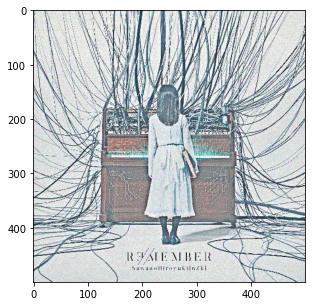

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(gen_tensor))
plt.show()